In [308]:
import numpy as np
import os
import random 
import unittest
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import wrappers
import tensorflow as tf
from tensorflow.keras import layers, models
import time
import uuid
import qmath

In [32]:
MAX_STEPS = 2000

In [3]:
def extract_array(input, start_index, dx, dy, reduce = True):
    c = dx * dy
    arr = input[start_index: start_index + c]
    nparr = np.array(arr)

    if dy == 1 and reduce:
        if dx == 1:
            nparr =arr[0]
        else:
            nparr = nparr.reshape((dx, ))
    else:
        nparr = nparr.reshape((dx, dy))
        
    return nparr

In [4]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [6]:
class SimpleNN:
    def __init__(self):
        # Initialize weights and biases
        self.W1 = np.random.randn(8, 8) * 0.01
        self.b1 = np.zeros((1, 8))
        self.W2 = np.random.randn(8, 8) * 0.01
        self.b2 = np.zeros((1, 8))
        self.W3 = np.random.randn(8, 4) * 0.01
        self.b3 = np.zeros((1, 4))

    def set_trainable_weights(self, input_weights):
        start_index = 0
        dx = 8
        dy = 8
        self.W1 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy

        dx = 1
        dy = 8
        self.b1 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy        

        dx = 8
        dy = 8
        self.W2 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy

        dx = 1
        dy = 8
        self.b2 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy        
        
        dx = 8
        dy = 4
        self.W3 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy

        dx = 1
        dy = 4
        self.b3 = extract_array(input_weights, start_index, dx, dy)
        start_index += dx * dy        
        #print('start_index ' + str(start_index))

    def forward(self, X):
        # Forward pass
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = softmax(self.Z3)
        return self.A3

    def predict(self, X):
        # Predict method
        probabilities = self.forward(X)
        return probabilities

In [42]:
def create_environment():
    global MAX_STEPS
    env = gym.make("LunarLander-v2", render_mode = None, enable_wind = False, max_episode_steps = MAX_STEPS)
    observation, info = env.reset(seed=42)    
    return env

In [43]:
def generate_normal_random_number(sigma):
    return np.random.normal(0.0, sigma)

In [68]:
def generate_random_number():
    return random.random()

In [320]:
def fitness_function(chromosome):
    global MAX_STEPS
    observation, info = ENV.reset(seed=42)
    #observation, info = ENV.reset()

    MODEL.set_trainable_weights(chromosome)

    for ix in range(MAX_STEPS):
        observation_2 = np.expand_dims(observation, axis=0)
        action_prob = MODEL.predict(observation_2)
        
        action = np.argmax(action_prob)
        observation, reward, terminated, truncated, info = ENV.step(action)

        if terminated or truncated:
            break   

    px = observation[0]
    py = observation[1]

    distance = math.sqrt(px * px + py * py)
    distance_alt = 1 + distance * 10
    distance_alt_mult = distance_alt * distance_alt

    if reward < 0.0:
        fitness = reward
        fitness += 101
        fitness *= ix / distance_alt_mult
    else:
        fitness = 1000000 + ((reward + 101) ** 4) / (ix * distance_alt_mult)
    
    return (fitness, reward, ix, distance)

In [321]:
MAX_FITNESS = 0.0

In [322]:
def compute_fitness(ch):
    global MAX_FITNESS
    time_start = time.time()
    (fitness, reward, ix, distance) = fitness_function(ch.chromosome)
    time_end = time.time()
    time_diff = time_end - time_start
    #print((fitness, reward, ix, time_diff))
    if fitness > MAX_FITNESS:
        print((fitness, reward, ix, time_diff, distance))
        MAX_FITNESS = fitness
    return fitness

In [323]:
class Chromosome(object):

    def __init__(self, ch):
        self.chromosome = ch
        self.id = uuid.uuid4()

        fitness = compute_fitness(self)
        
        self.fitness = fitness
    
    def __str__(self):
        return f'Chromosome:{self.chromosome}, fitness:{self.fitness}'

    def __repr__(self):
        return self.__str__()

In [324]:
def generate_random_float_chromosome(ch_le):
    return np.random.normal(0.0, 1.0, ch_le)

In [325]:
def generate_random_population(count, ch_le):
    res = []
    for _ in range(0, count):
        ch = generate_random_float_chromosome(ch_le)

        chromosome = Chromosome(ch)
        
        res.append(chromosome)

    return res

In [326]:
initial_population_size = 1000
chromosome_length = 180  #756
mutation_probability = 0.05
iterations = 30

In [327]:
ENV = create_environment()

In [328]:
MODEL = SimpleNN()

In [329]:
MAX_FITNESS = 0.0

In [330]:
pop = generate_random_population(5, chromosome_length)
#pop

(4.126714777146809, -100, 79, 0.013425588607788086, 0.3375335085093713)
(58.11662633991235, -100, 83, 0.004944324493408203, 0.019505762815499067)


In [331]:
def mutate_chromosome(chromosome, mutation_probability):
    mutated = False
    for ix in range(0, len(chromosome.chromosome)):
        if generate_random_number() <= mutation_probability:
            val = chromosome.chromosome[ix]
            diff = generate_normal_random_number(0.1)
            chromosome.chromosome[ix] = val + diff
            mutated = True

    fitness = compute_fitness(chromosome)
    
    chromosome.fitness = fitness

    return chromosome

In [332]:
mutate_chromosome(pop[0], 0.1)

Chromosome:[-1.21119291  1.36861341  1.54111399 -0.1544695  -2.66020093  0.67308169
 -1.82233005 -0.64858839  1.25161537  0.75781932 -0.4142604   0.94340344
  0.4312918   0.83301315 -0.6284467  -0.21357135  0.86359162  0.22874654
  1.17443139 -1.29201169 -0.45418802  2.23136553 -0.45023094  0.50909878
  0.54724881  2.12273827 -1.30362214  0.67028319  0.61432718  0.39470545
  0.04106749  0.54677985  0.45080198  0.85651887  0.08057963  1.86850114
  1.19250593 -1.14422555  0.44159364  1.92979543  3.46417781  0.05039209
  0.1592117  -0.84090596 -0.3477359   1.72852232  0.47636405 -1.32535729
  1.61298427 -1.7038556  -1.30047956 -1.11253204  1.30494331  1.71927615
 -0.12142625 -0.36134205 -0.78427022 -1.82071705  0.31951163 -2.12495699
  0.09445071 -0.34780188  0.30281022  0.17010819 -1.18415222 -0.85024364
  0.34033247  0.14668682 -0.36771983 -2.07182511 -1.08688243  0.31756966
  0.05628488  0.03110418 -0.80871838 -1.46334844  0.11138397  0.07936847
 -0.69661578  1.41966094 -0.21221809 -0.

In [333]:
def crossover_chromosome_pair_with_cutpoint(cha, chb, cut_point):
    ch_len = len(cha.chromosome)
    chc = np.concatenate((cha.chromosome[0:cut_point], chb.chromosome[cut_point: ch_len]))
    chd = np.concatenate((chb.chromosome[0:cut_point], cha.chromosome[cut_point: ch_len]))

    ch1 = Chromosome(chc)
    ch2 = Chromosome(chd)

    return (ch1, ch2)

In [334]:
def crossover_chromosome_pair(cha, chb):
    ch_len = len(cha.chromosome)
    cut_point = int(random.random() * (ch_len + 1))

    return crossover_chromosome_pair_with_cutpoint(cha, chb, cut_point)

In [335]:
def compute_summary_fitness(population):
    summary_fitness = 0.0

    for ch in population:
        summary_fitness += ch.fitness

    return summary_fitness

In [336]:
def select_chromosome(old_population, summary_fitness):
    selector_value = summary_fitness * generate_random_number()
    sum = 0.0
    for ch in old_population:
        sum += ch.fitness
        if selector_value <= sum:
            return ch

    raise ValueError("WTF")

In [337]:
def generate_new_population(old_population, new_population_size, mutation_probability):
    new_population = []
    summary_fitness = compute_summary_fitness(old_population)

    for ix in range(0, new_population_size // 2):
        selector_value = summary_fitness * generate_random_number()
        sum = 0.0

        cha = select_chromosome(old_population, summary_fitness)
        chb = select_chromosome(old_population, summary_fitness)

        (chc, chd) = crossover_chromosome_pair(cha, chb)
        chc = mutate_chromosome(chc, mutation_probability)
        chd = mutate_chromosome(chd, mutation_probability)

        new_population.append(chc)
        new_population.append(chd)

    return new_population

In [338]:
def find_best_chromosome(population):
    res = population[0]
    
    for ch in population:
        if ch.fitness > res.fitness:
            res = ch

    return res

In [339]:
def find_worst_chromosome(population):
    res = population[0]
    
    for ch in population:
        if ch.fitness < res.fitness:
            res = ch

    return res

In [340]:
def main_loop(iterations, initial_population_size, chromosome_length, mutation_probability, log_best):
    population = generate_random_population(initial_population_size, chromosome_length)

    best_fitness = []
    worst_fitness = []
    best_history = []
    
    for ix in range(0, iterations):
        print('Iteration ' + str(ix))
        new_population = generate_new_population(population, initial_population_size, mutation_probability)
        population = new_population
        best = find_best_chromosome(population)
        worst = find_worst_chromosome(population)
        best_fitness.append(best.fitness)
        worst_fitness.append(worst.fitness)
        best_history.append(best)
        if log_best:
            print(best.fitness)

    result = (find_best_chromosome(best_history), population, best_fitness, worst_fitness, best_history)

    return result

In [341]:
result = main_loop(30, initial_population_size, chromosome_length, mutation_probability, True)

(72.73926289778593, -100, 84, 0.016007423400878906, 0.007462068307507651)
Iteration 0
(76.78150691468191, -100, 104, 0.0, 0.016382680080967403)
(83.20831739801656, -100, 102, 0.015758514404296875, 0.010717613454180826)
(151.46035167203112, -100, 234, 0.01554560661315918, 0.024296370787387153)
151.46035167203112
Iteration 1
73.35447885809442
Iteration 2
(1069555.0787739397, 100, 311, 0.022478818893432617, 0.7686553462612874)
70.32019548857302
Iteration 3
75.88450857206783
Iteration 4
83.66400756398272
Iteration 5
107.46771548731694
Iteration 6
77.54216348887618
Iteration 7
(1085936.3453679546, 100, 376, 0.015624761581420898, 0.6107383540038988)
(1107498.2270043031, 100, 378, 0.015633106231689453, 0.5337902651123168)
1107498.2270043031
Iteration 8
(1129417.4151194596, 100, 314, 0.015634536743164062, 0.5337689091283332)
(1149017.392460643, 100, 276, 0.009136438369750977, 0.5299688767795668)
(1303420.3597968286, 100, 255, 0.00826120376586914, 0.35930340509852904)
(1314505.2020138372, 100, 

In [342]:
(best, population, best_fitness, worst_fitness, best_history) = result

In [343]:
best = find_best_chromosome(best_history)

In [344]:
ENV.close()

In [345]:
best

Chromosome:[ 1.29396207 -0.16572333 -1.41568154  0.8582572   0.68287582  1.38416836
  0.45578971 -0.7915158   0.20509325 -1.10012287 -1.45661262  0.57397789
 -0.71014674 -1.36301634  1.18743518 -0.31622575  1.05119282 -0.41626068
  0.58587743  0.51455918  2.0102371   0.41010753  0.58038904  0.50886003
  0.45348922 -2.73873834 -2.14057485 -1.01895254 -0.8906768   0.57946885
 -0.67211016 -0.40755687  0.98213129 -0.48599059  0.28247411  0.65870854
 -1.47961882 -0.30416004  0.11045934  0.33082538 -0.28370291  0.44213959
 -0.85591977  0.80189579 -1.274897    0.39736777  0.68766306 -2.89888049
  1.31906026  0.17841796 -0.99655412 -0.08334883 -0.27793263 -0.46691922
  0.17841893 -1.07580781  0.50064152  1.01994058 -1.59872812  0.78785938
 -1.29908973  1.20643177 -0.61175668  1.53915353  0.68979962  0.91723364
  1.40240327 -0.14553908  1.01940499  0.30031236  0.55872188 -0.67898706
 -0.0940692   1.31495958 -0.68362882 -0.79717045 -0.0792626   2.83845505
  0.26334126 -0.95964014 -1.18678301 -0.

In [346]:
MODEL.set_trainable_weights(best.chromosome)  

In [376]:
test_env = gym.make("LunarLander-v2", render_mode = 'human', enable_wind = False, max_episode_steps = 100000)

In [377]:
observation, info = test_env.reset(seed=42)
#observation, info = test_env.reset()

In [378]:
for ix in range(1000):
    observation_2 = np.expand_dims(observation, axis=0)
    action_prob = MODEL.predict(observation_2)
    
    action = np.argmax(action_prob)
    observation, reward, terminated, truncated, info = test_env.step(action)

    if terminated or truncated:
        #print(reward)
        observation, info = test_env.reset()
        #break

test_env.close()

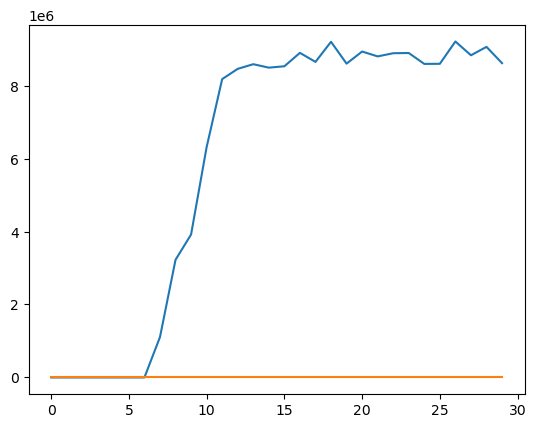

In [350]:
plt.plot(best_fitness)
plt.plot(worst_fitness)
plt.show()